# EDA
Проверить взаимосвязи между параметрами измерений, найти потенциальные особенности для построения модели.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.pyplot import rcParams
from typing import List

rcParams['figure.figsize'] = 16, 8

In [2]:
buildings = pd.read_csv("../data/buildings.csv")
weather = pd.read_csv("../data/weather.csv")
energy = pd.read_csv("../data/train.0.zip")

## Оптимизация памяти

In [3]:
def reduce_mem_usage(df: pd.DataFrame):
    start_mem = df.memory_usage().sum()/1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        
        if str(col_type)[:5] == "float":
            c_min = df[col].min()
            c_max = df[col].max()
            
            if c_min > np.finfo("f2").min and c_max < np.finfo("f2").max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo("f4").min and c_max < np.finfo("f4").max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)

        elif str(col_type)[:3] == "int":
            c_min = df[col].min()
            c_max = df[col].max()
            
            if c_min > np.iinfo("i1").min and c_max < np.iinfo("i1").max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo("i2").min and c_max < np.iinfo("i2").max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo("i4").min and c_max < np.iinfo("i4").max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo("i8").min and c_max < np.iinfo("i8").max:
                df[col] = df[col].astype(np.int64)
            
        elif col == "timestamp":
            df[col] = pd.to_datetime(df[col])
        
        elif str(col_type)[:8] != "datetime":
            df[col] = df[col].astype("category")
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Потребление памяти меньше на - {round(start_mem - end_mem, 2)} Мб (минус {round(100*(start_mem - end_mem)/start_mem, 1)}%)")
    return df

In [4]:
buildings = reduce_mem_usage(buildings)
weather = reduce_mem_usage(weather)
energy = reduce_mem_usage(energy)

Потребление памяти меньше на - 0.05 Мб (минус 73.9%)
Потребление памяти меньше на - 6.53 Мб (минус 68.1%)
Потребление памяти меньше на - 195.54 Мб (минус 53.1%)


## Объединение данных

In [5]:
energy = pd.merge(
    left=energy,
    right=buildings,
    how="left",
    left_on="building_id",
    right_on = "building_id",
)

energy = energy.set_index(["timestamp", "site_id"])
weather = weather.set_index(["timestamp", "site_id"])

energy = pd.merge(
    left=energy,
    right=weather,
    how="left",
    left_index=True,
    right_index=True,
)

energy.reset_index(inplace=True)
print(energy.head())

   timestamp  site_id  building_id  meter  meter_reading primary_use  \
0 2016-01-01        0            0      0            0.0   Education   
1 2016-01-01        0            1      0            0.0   Education   
2 2016-01-01        0            2      0            0.0   Education   
3 2016-01-01        0            3      0            0.0   Education   
4 2016-01-01        0            4      0            0.0   Education   

   square_feet  year_built  floor_count  air_temperature  cloud_coverage  \
0         7432      2008.0          NaN             25.0             6.0   
1         2720      2004.0          NaN             25.0             6.0   
2         5376      1991.0          NaN             25.0             6.0   
3        23685      2002.0          NaN             25.0             6.0   
4       116607      1975.0          NaN             25.0             6.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0               

In [6]:
print(energy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12060910 entries, 0 to 12060909
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   timestamp           datetime64[ns]
 1   site_id             int64         
 2   building_id         int16         
 3   meter               int8          
 4   meter_reading       float32       
 5   primary_use         category      
 6   square_feet         int32         
 7   year_built          float16       
 8   floor_count         float16       
 9   air_temperature     float16       
 10  cloud_coverage      float16       
 11  dew_temperature     float16       
 12  precip_depth_1_hr   float16       
 13  sea_level_pressure  float16       
 14  wind_direction      float16       
 15  wind_speed          float16       
dtypes: category(1), datetime64[ns](1), float16(9), float32(1), int16(1), int32(1), int64(1), int8(1)
memory usage: 529.1 MB
None


## Очистка данных

In [7]:
def round_fillna(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    for col in columns:
        type_ = "int8"
        if col in ["wind_direction", "year_built", "precip_depth_1_hr"]:
            type_ = "int16"
        if col == "precip_depth_1_hr":
            df[col] = df[col].apply(lambda x: 0 if x<0 else x)
        df[col] = np.round(df[col].fillna(value=0)).astype(type_)
    return df

In [8]:
energy = energy.drop(columns=["meter"], axis=1)
energy = round_fillna(
    energy,
    [
        "wind_direction",
        "wind_speed",
        "cloud_coverage",
        "precip_depth_1_hr",
        "year_built",
        "floor_count",
    ]
)

energy = energy[energy["meter_reading"]>0]
del buildings
del weather
print(energy.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11530741 entries, 45 to 12060909
Data columns (total 15 columns):
 #   Column              Dtype         
---  ------              -----         
 0   timestamp           datetime64[ns]
 1   site_id             int64         
 2   building_id         int16         
 3   meter_reading       float32       
 4   primary_use         category      
 5   square_feet         int32         
 6   year_built          int16         
 7   floor_count         int8          
 8   air_temperature     float16       
 9   cloud_coverage      int8          
 10  dew_temperature     float16       
 11  precip_depth_1_hr   int16         
 12  sea_level_pressure  float16       
 13  wind_direction      int16         
 14  wind_speed          int8          
dtypes: category(1), datetime64[ns](1), float16(3), float32(1), int16(4), int32(1), int64(1), int8(3)
memory usage: 549.8 MB
None


## Поиск зависимостей

#### здания

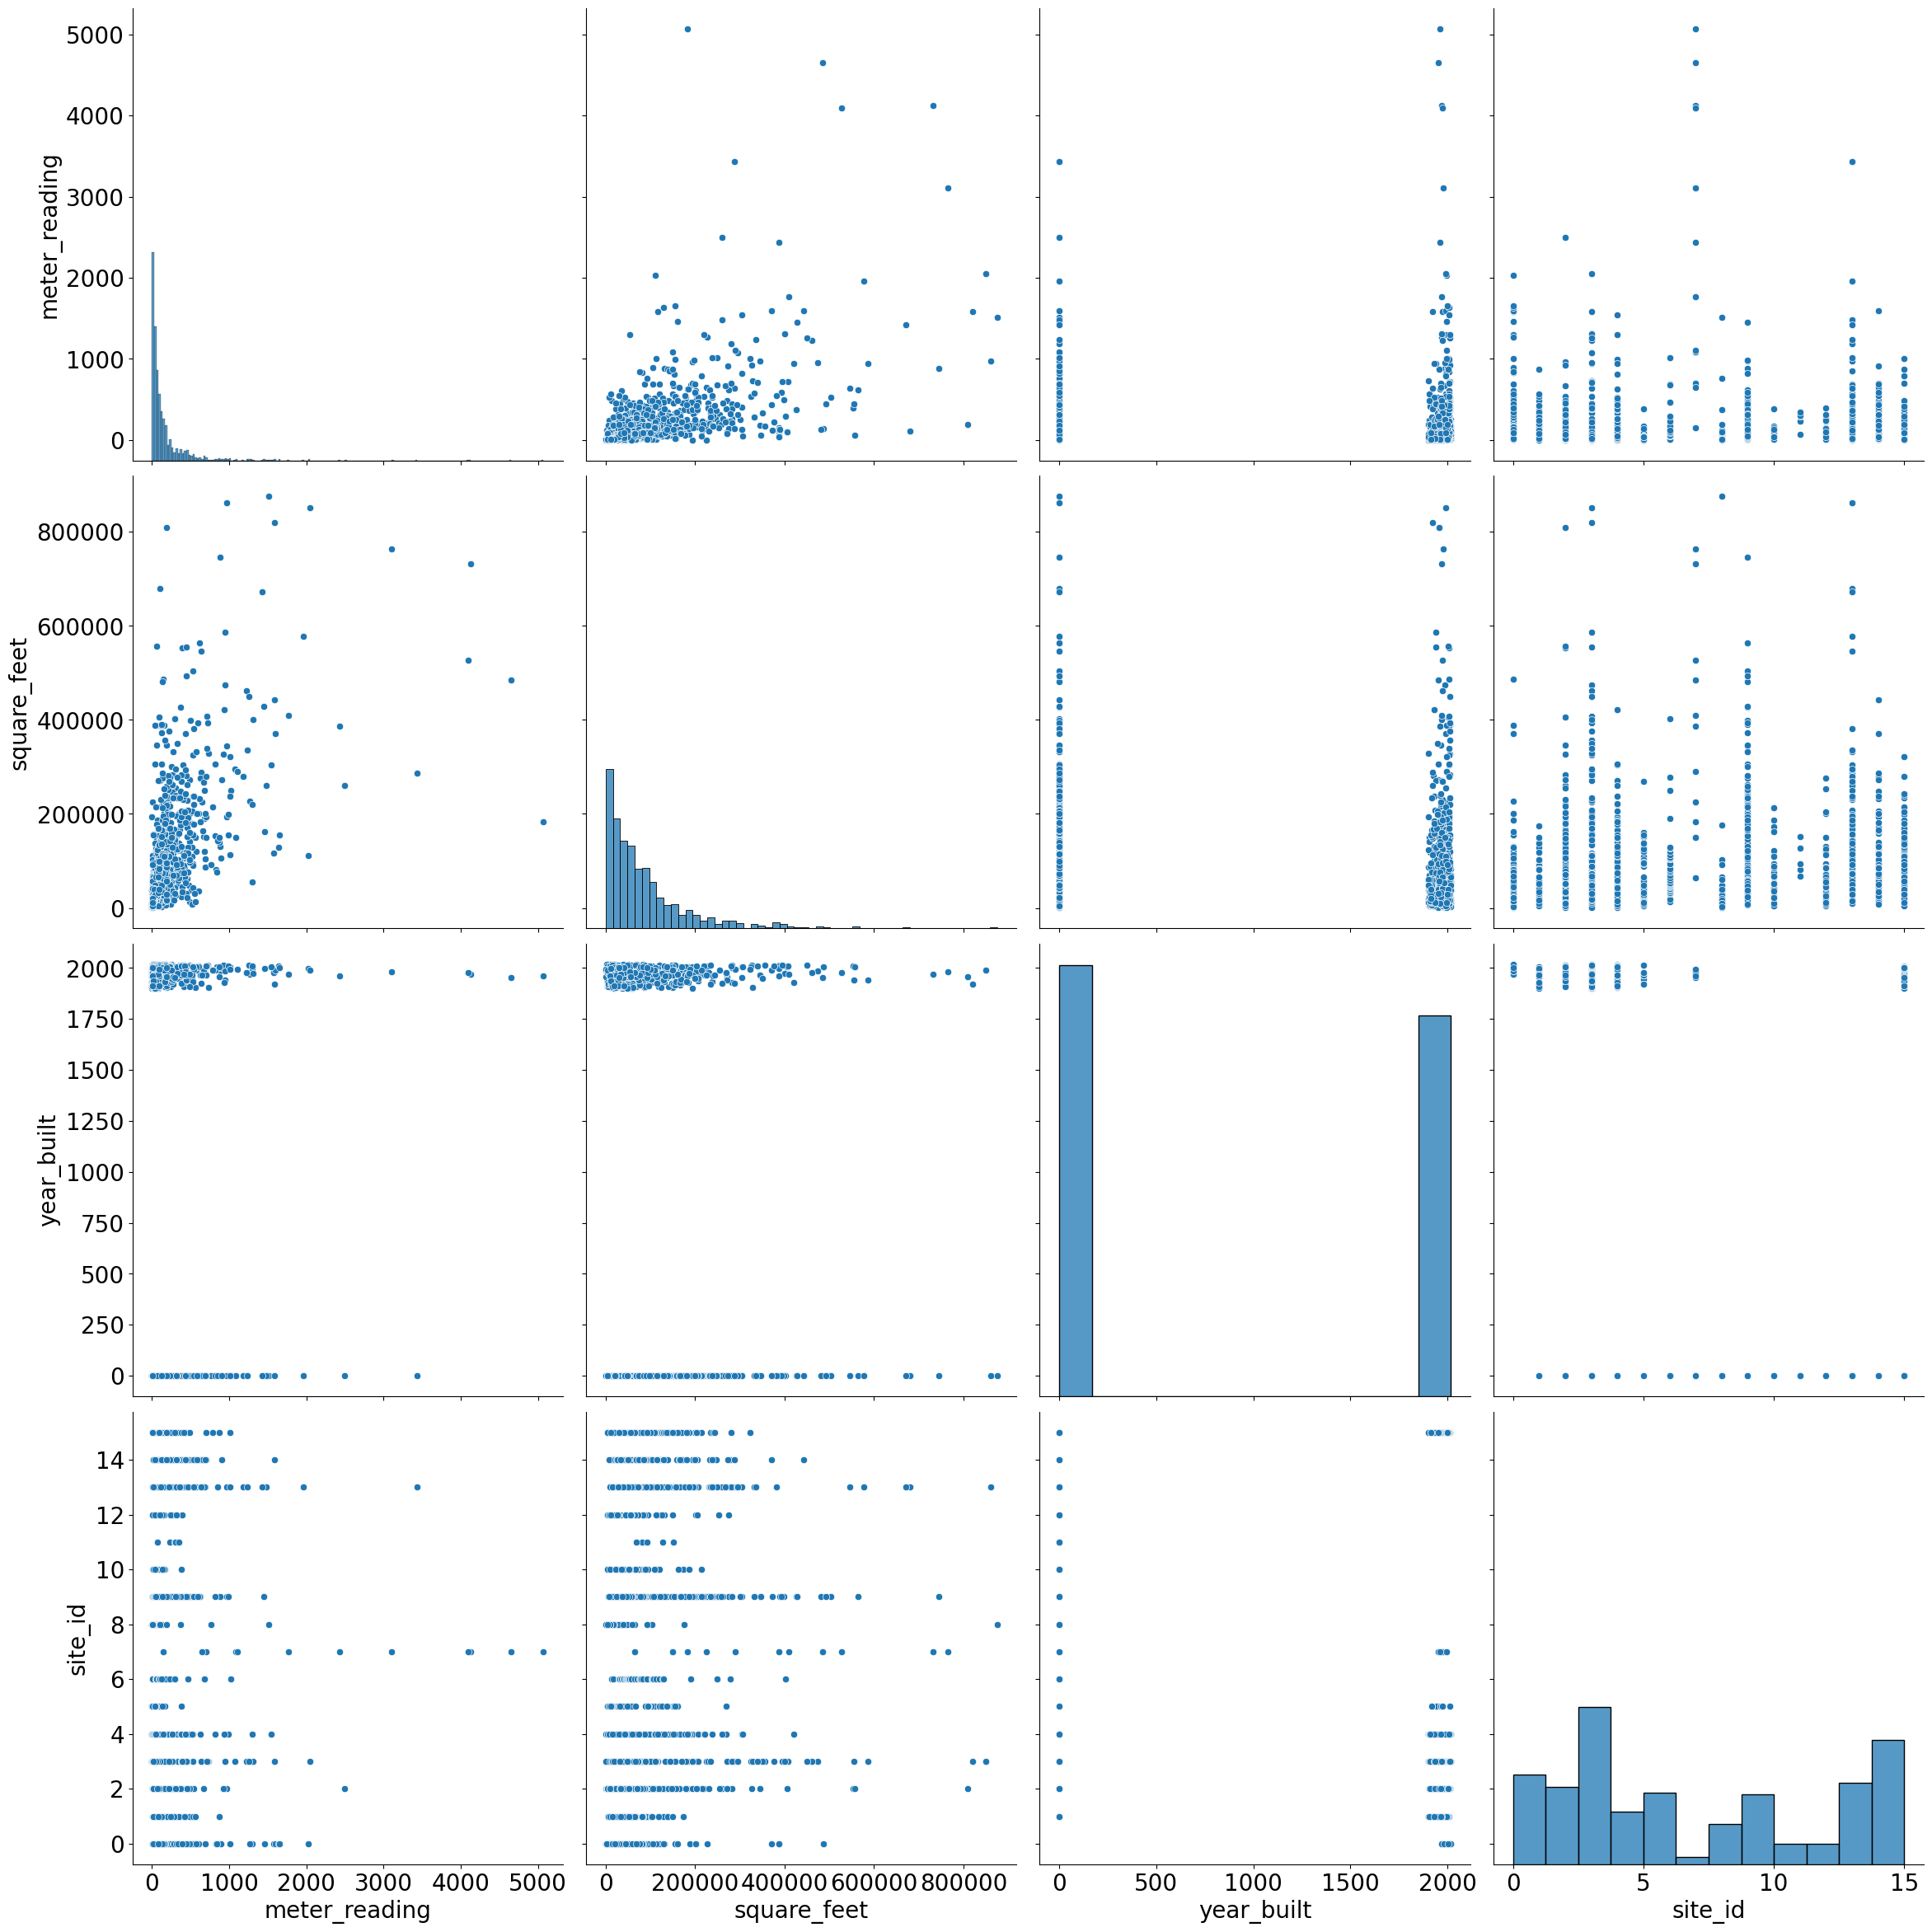

In [20]:
eg = energy.groupby("building_id")
eg = eg[["meter_reading",
        "square_feet",
        "year_built",
        "site_id",]].mean()

data_corr_meta = pd.DataFrame(eg)
data_corr_meta.dropna(inplace=True)
sns.pairplot(data_corr_meta, height=6)
plt.show()
del data_corr_meta
del eg

#### погода

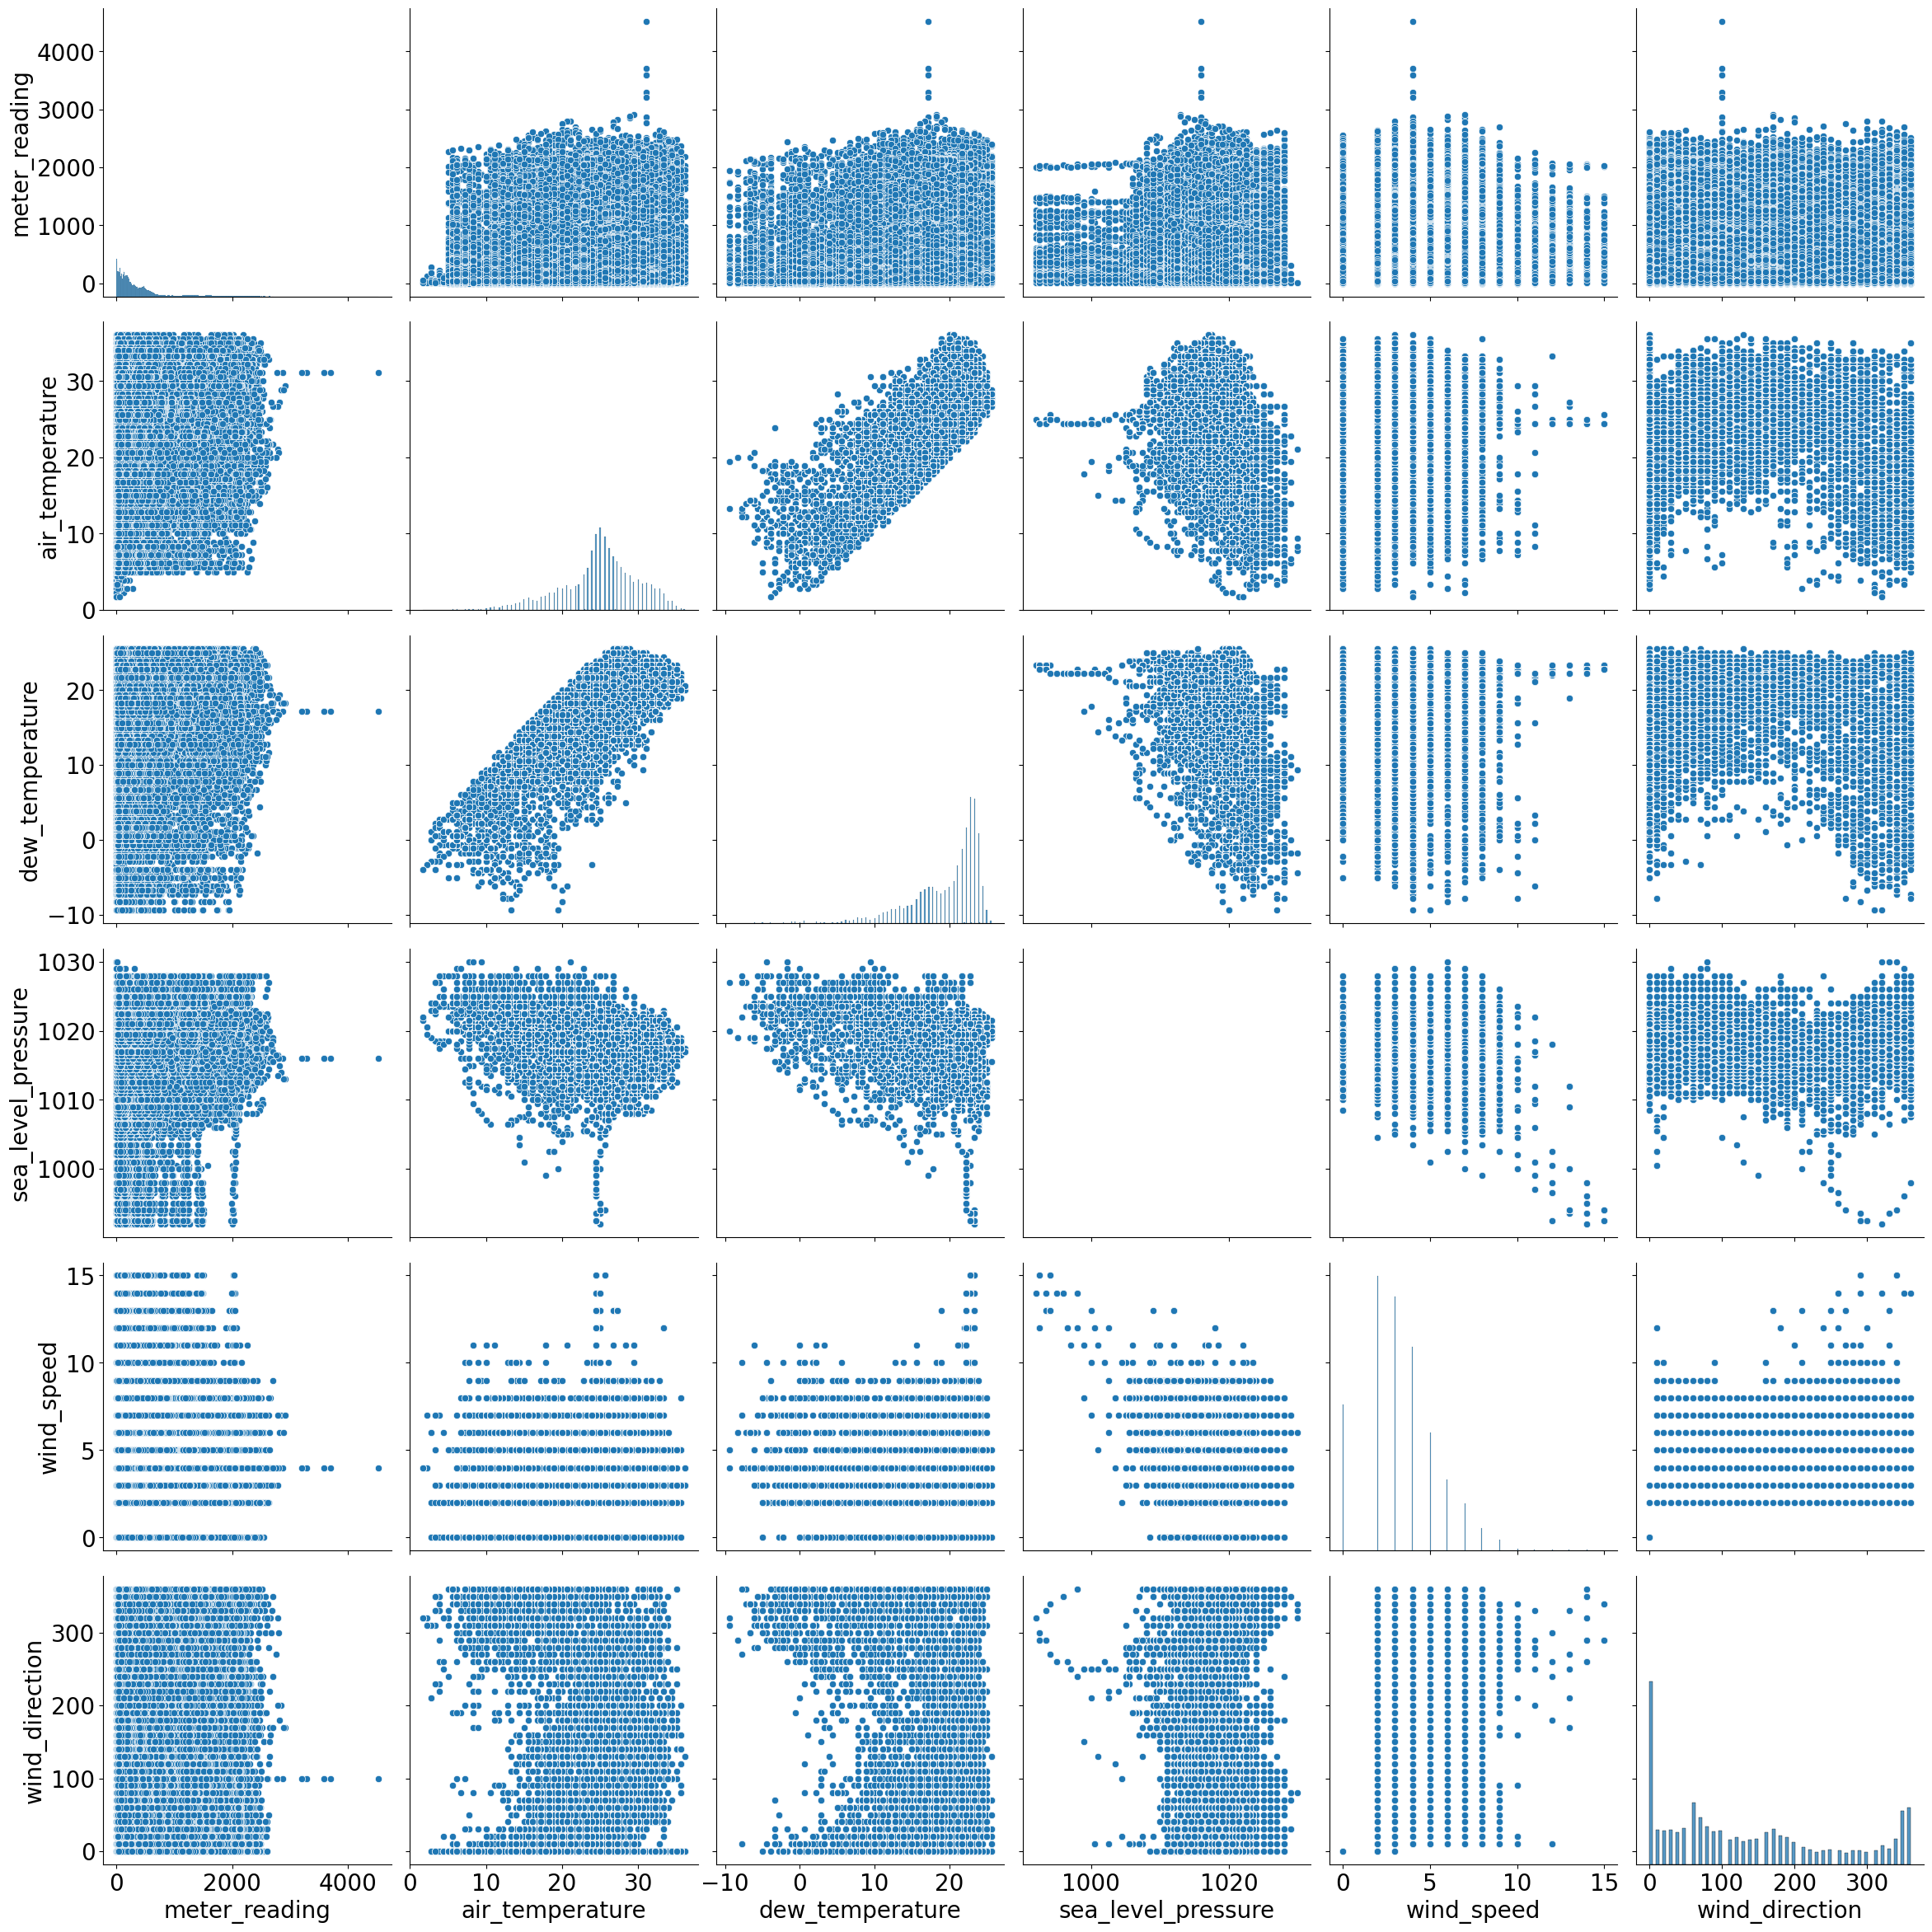

In [21]:
data_corr_weather = pd.DataFrame(
    energy[energy["site_id"] == 0],
    columns=[
        "meter_reading",
        "air_temperature",
        "dew_temperature",
        "sea_level_pressure",
        "wind_speed",
        "wind_direction",
    ]
)
data_corr_weather.dropna(inplace=True)
sns.pairplot(data_corr_weather, height=4)
plt.show()
del data_corr_weather

#### тип здания

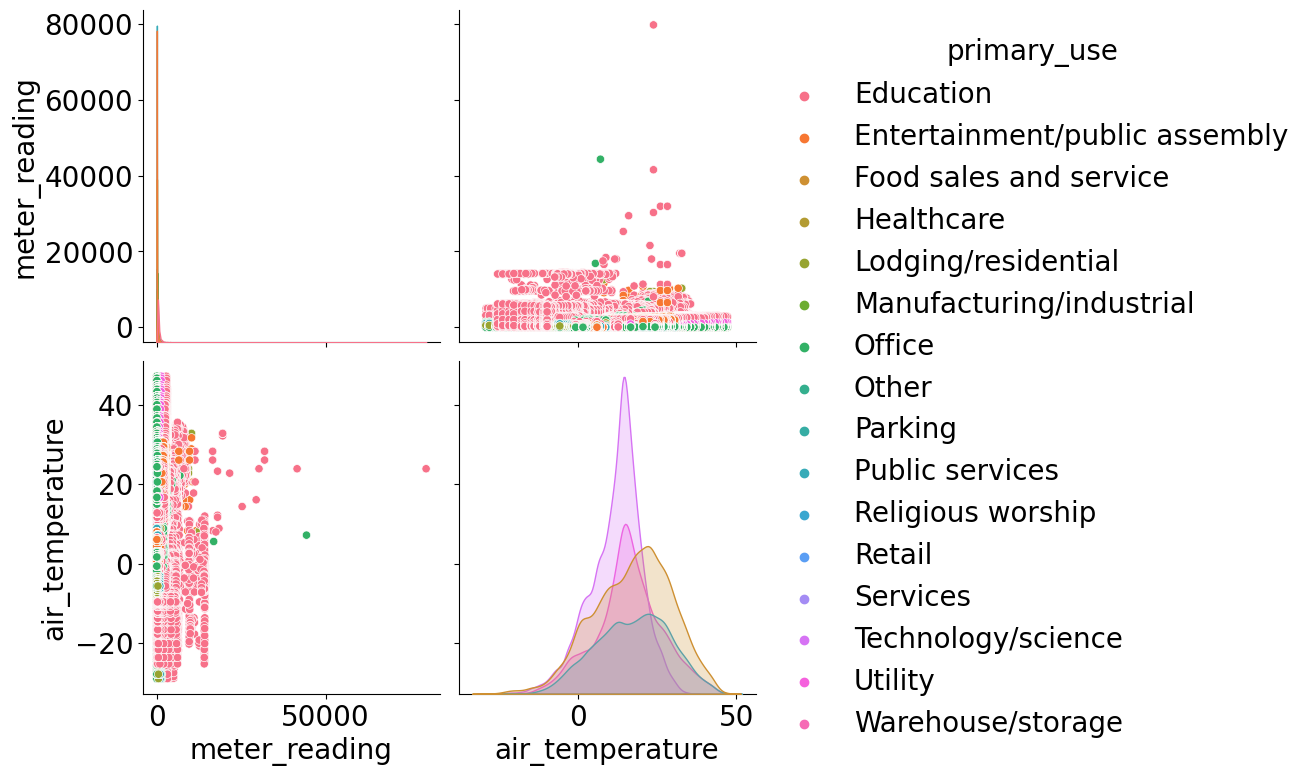

In [22]:
data_corr_temp_primary = pd.DataFrame(
    energy,
    columns=[
        "meter_reading",
        "air_temperature",
        "primary_use",
    ]
)
data_corr_temp_primary.dropna(inplace=True)
sns.pairplot(data_corr_temp_primary, hue="primary_use", height=4)
plt.show()
del data_corr_temp_primary

#### время

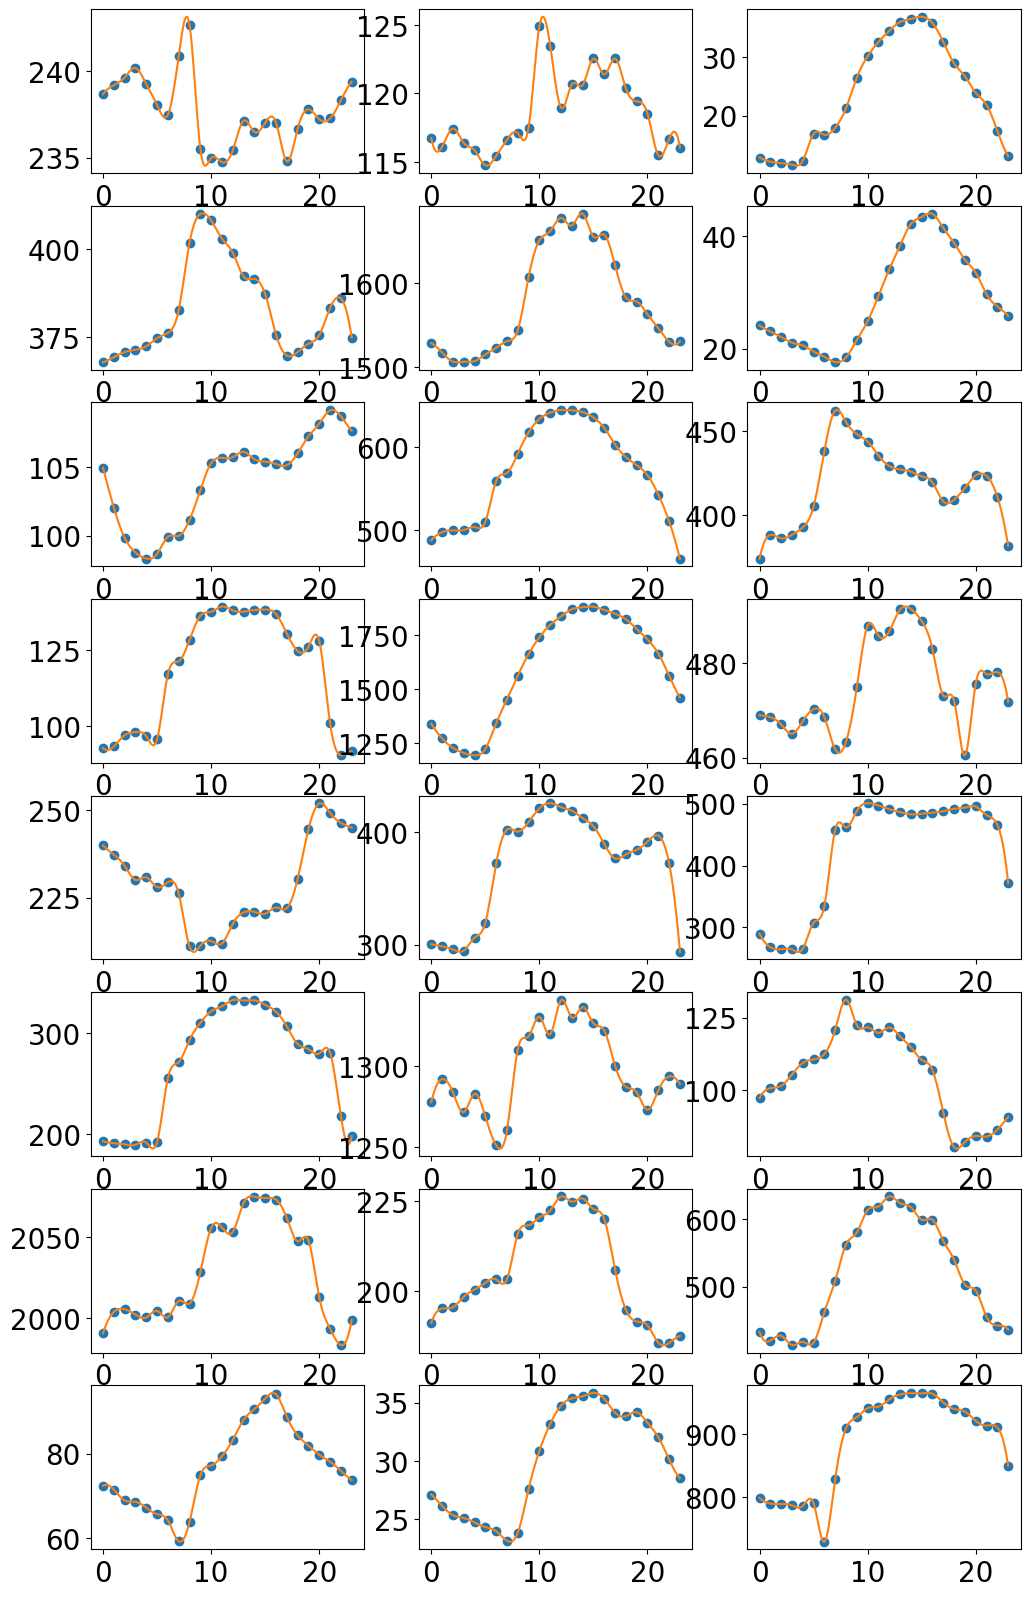

In [26]:
energy["hour"] = energy["timestamp"].dt.hour.astype("int8")
fig = plt.figure(figsize=(12, 20))
for i in range(0, 24):
    fig.add_subplot(8, 3, i+1)
    train_df_i = energy[(energy["building_id"]==i) & (energy["meter_reading"]>0)]
    train_df_i_hourly = train_df_i.groupby("hour")
    train_df_i_hourly = train_df_i_hourly[["meter_reading"]].mean().reset_index()
    x = np.arange(0, 24)
    y = interp1d(x, train_df_i_hourly["meter_reading"], kind="cubic")
    xn = np.arange(0, 23.1, 0.1)
    yn = y(xn)
    plt.plot(
        np.arange(0, 24),
        train_df_i_hourly["meter_reading"], "o", xn, yn, "-"
    )

plt.show()

#### дата

In [36]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dates_range = pd.date_range(start='2015-12-31', end='2017-01-01')
us_holidays = calendar().holidays(
    start=dates_range.min(),
    end=dates_range.max()
)

energy["dayofweek"] = energy["timestamp"].dt.dayofweek.astype("int8")
energy["day"] = energy["timestamp"].dt.day.astype("int8")
energy["dayofyear"] = energy["timestamp"].dt.dayofyear.astype("int16")
energy["month"] = energy["timestamp"].dt.month.astype("int8")
energy["week"] = energy["timestamp"].dt.isocalendar().week.astype("int8")
energy["date"] = pd.to_datetime(energy["timestamp"].dt.date)
energy["is_holiday"] = (energy["date"].isin(us_holidays)).astype("int8")


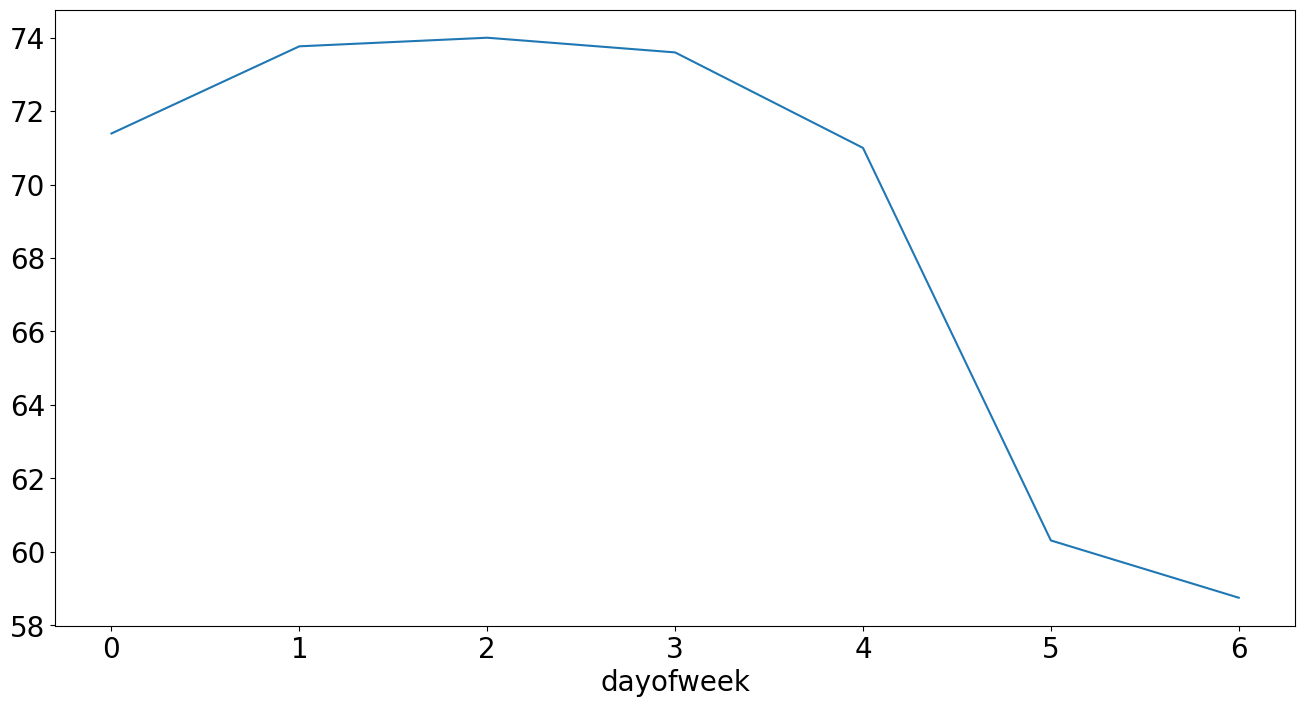

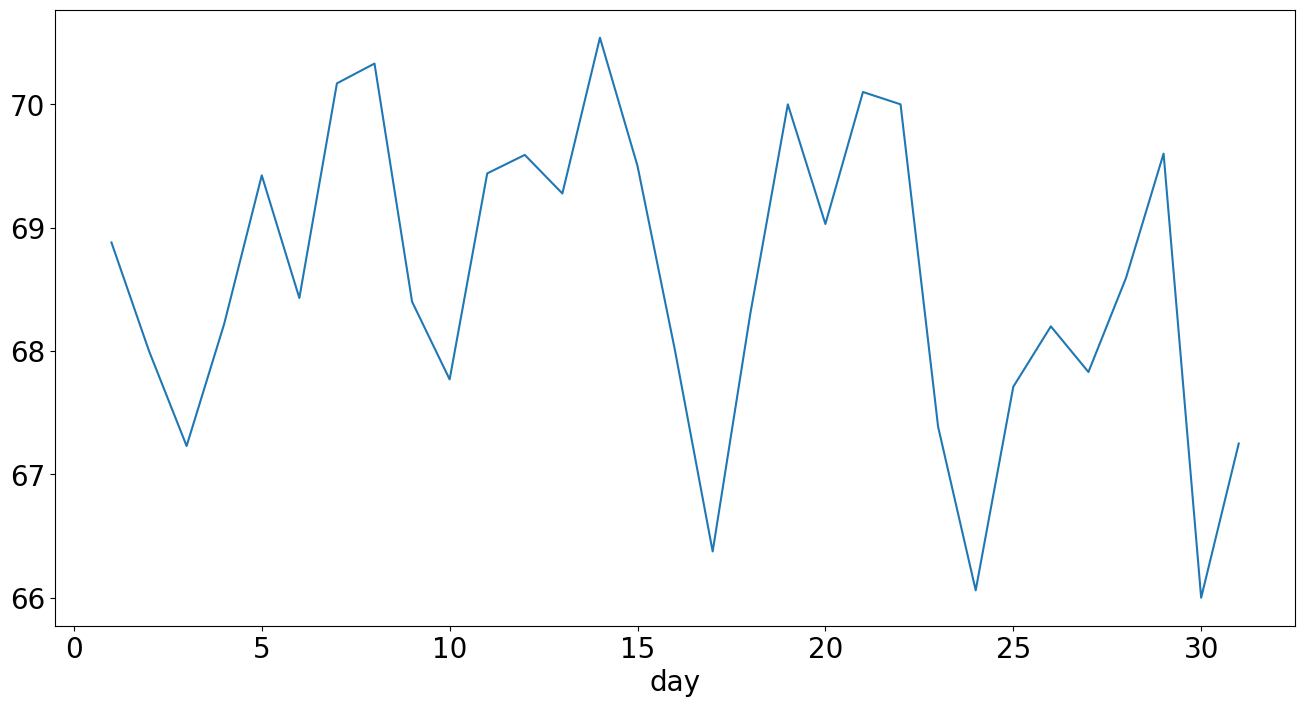

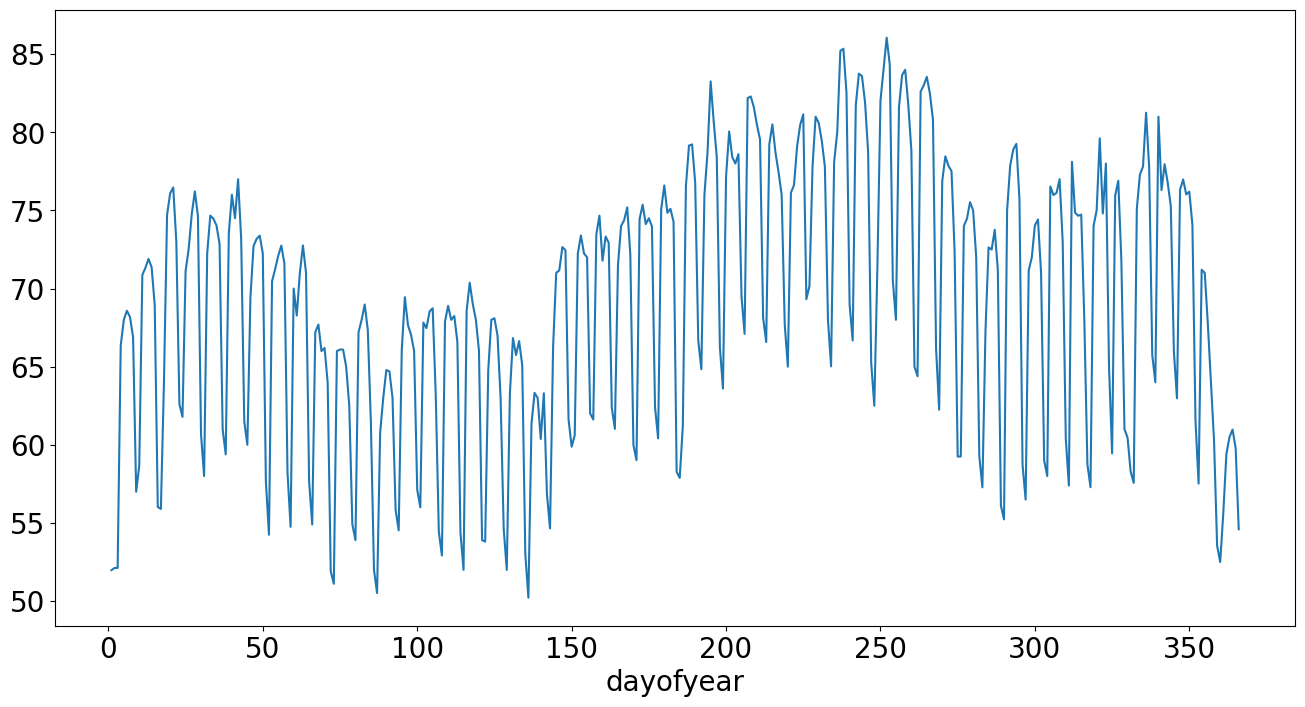

In [37]:
energy.groupby("dayofweek")["meter_reading"].median().plot()
plt.show()
energy.groupby("day")["meter_reading"].median().plot()
plt.show()
energy.groupby("dayofyear")["meter_reading"].median().plot()
plt.show()

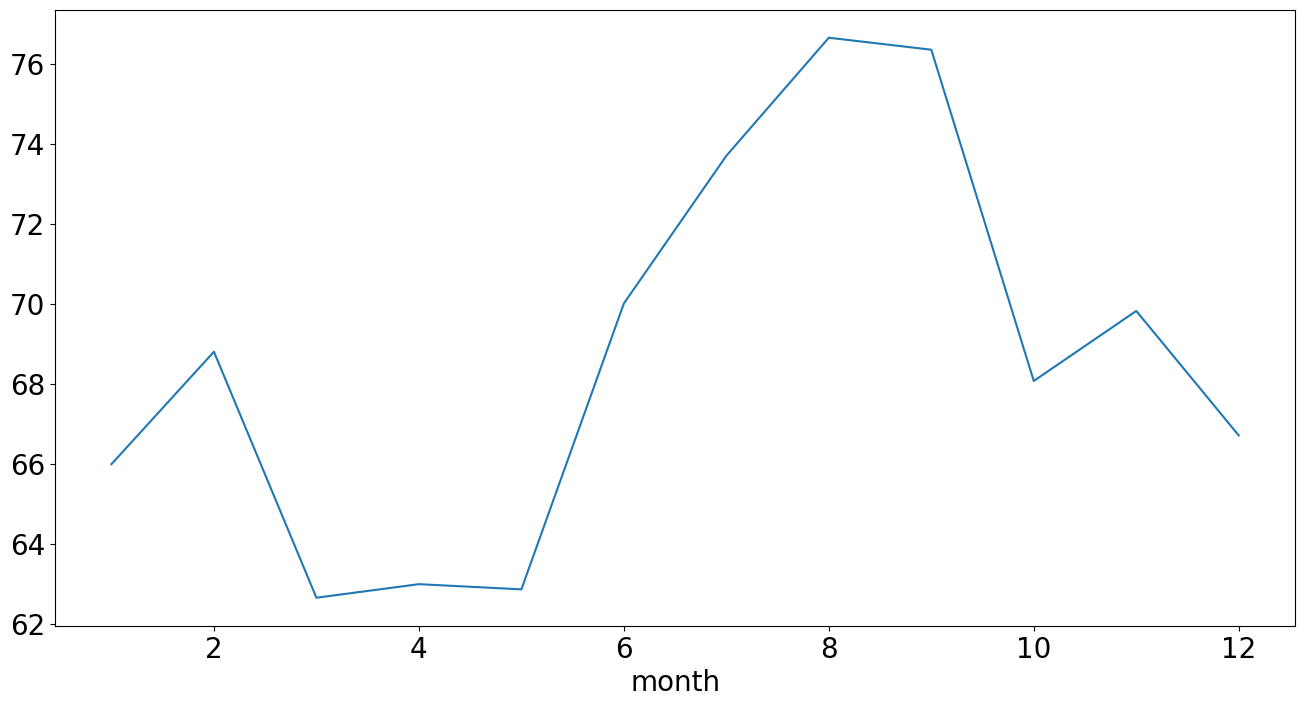

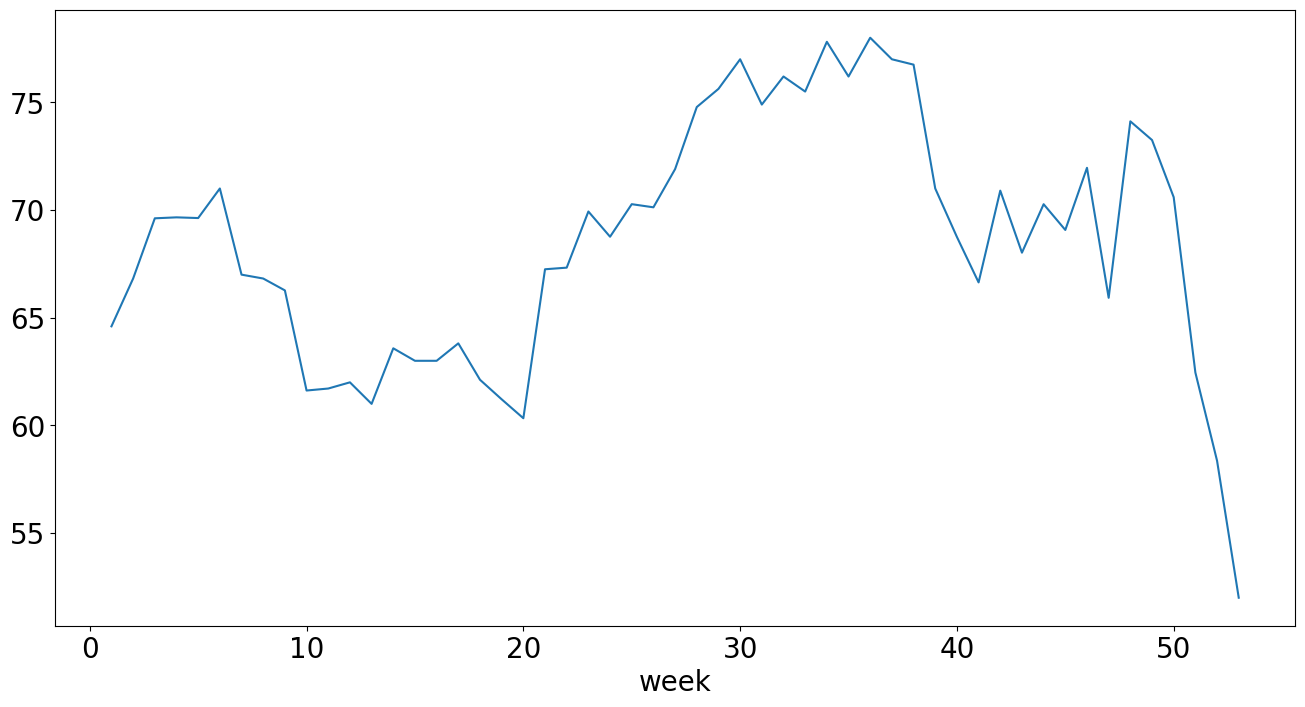

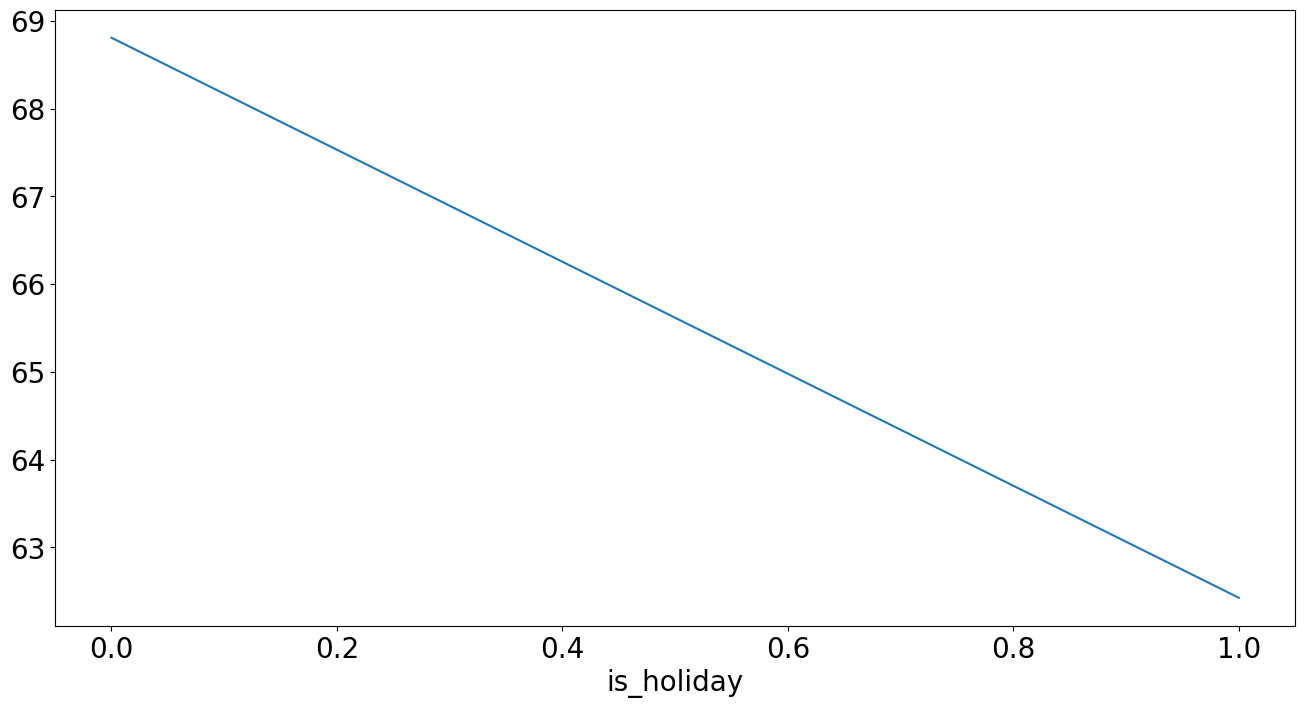

In [38]:
energy.groupby("month")["meter_reading"].median().plot()
plt.show()
energy.groupby("week")["meter_reading"].median().plot()
plt.show()
energy.groupby("is_holiday")["meter_reading"].median().plot()
plt.show()

In [41]:
del energy